# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators

Pablo Agustin Ortega Kral

# Utils and Imports

Importing all necessary libraries.


In [10]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [13]:
if os.path.exists('data'):
  shutil.rmtree('data')

os.mkdir('data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O data/data.zip
!unzip "data/data.zip"
os.system("rm data/data.zip")
data_dir = 'data/'


--2025-04-24 13:38:57--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 172.253.62.102, 172.253.62.139, 172.253.62.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2025-04-24 13:38:57--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.16.132, 2607:f8b0:4004:c17::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.16.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘data/data.zip’

data/data.zip       100%[===================>]   5.92M  --.-KB/s    in

Utils Functions.

In [14]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

![n-dot-l lighting illustration](/home/paok/Documents/coursework/ComputerVision-16720/hw6/figs/a.png)

Fig 2.a depicts the interaction of vectors respect to the surface of an object. Vector $\vec{l}$ represents direction of  the lighting source of the scene; $\vec{n}$ is the normal of the surface and $\vec{v}$ is the camera view vector. The area iluminated depends on the angle between the light source vector and the surface normal.

The dot product between the vectors arises as it precisely describes the cosine of the angle of the two vectors, scaled by their magnitude, allowing to compactly use them to model the radiance. In particular if  $\vec{l}$ and $\vec{n}$ are unit vectors then $\vec{n} \cdot \vec{l} = \cos{\theta_{\vec{l}\vec{n}}}$. 

The cosine of the angle, and thus the dot product $\vec{n} \cdot \vec{l}$, geometrically represents the scaling factor between the original surface $dA$ and the surface projected in the view of the light vector $\hat{dA}$.

$$\hat{dA} = dA \vec{n} \cdot \vec{l}$$

Notice that the radiance does not dependend on where we view the object from, rather it only depends of the relationship between the object's surface and the light source. As regardless of the viewpoint, the scattered light will be the same.



### Q 1 (b): Rendering the n-dot-l lighting (10 points)

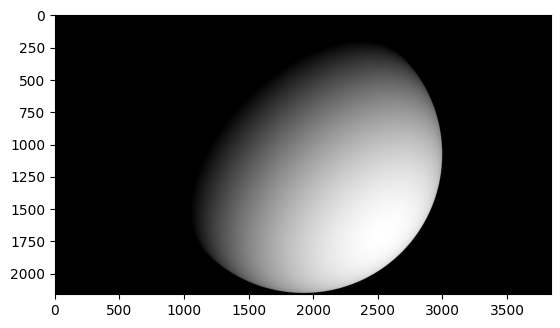

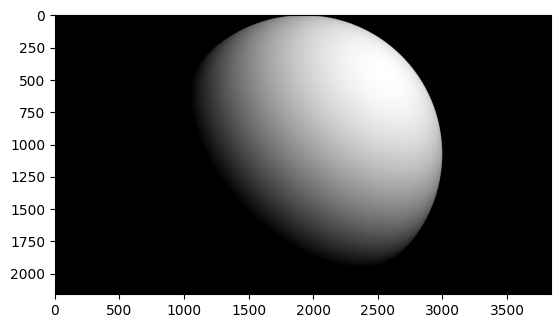

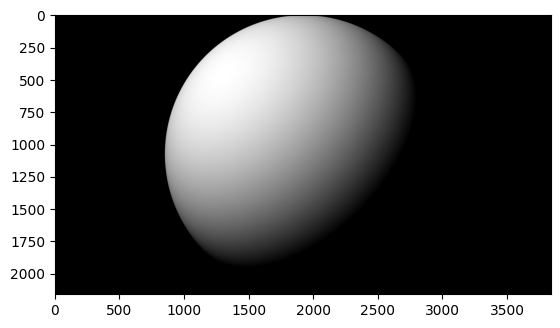

In [34]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None    
    # Get light vector
    light_vec = light/np.linalg.norm(light)
    # Get surface normals
    cx , cy, cz = center
    X = (X - cx)/rad
    Y = (Y - cy)/rad
    Z = (Z - cz)/rad
    normals = np.array([X, Y, Z])
    normals /= np.linalg.norm(normals)
    # Get dot product
    n_dot_l = np.dot(normals.T, light_vec)
    n_dot_l[n_dot_l < 0] = 0
    # Build the image
    # image = np.clip(n_dot_l, 0.0, 1.0).astype(np.float32)
    image = n_dot_l.astype(np.float32)
    image = image.T
    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [36]:
#NOTE:  I = L.T B
U, S ,Vh = np.linalg.svd(I, full_matrices=False)
print("Singular values: ", S)

Singular values:  [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]





1. Why should $I$ be rank 3?  

Theoritically given that the lighting direction have dimensions $L \in \mathbb{R}^{3 \times N}$ and the psuedo normal matrix has one column per point making it shape $B \in \mathbb{R}^{3 /times P}$, then there are a maximum of three linearly independent compnents forming $I$ meaning we should expect a rank of 3.

2. Do the singular values agree with this?

**A:** We can see that the all 7 singular values are different than 0, meaning that it is not purely speaking rank 3. However we can see that the first 3 values are significantly larger than the rest; while the remaining singular values are closer to 0. This occurs due to inherent noise in real world photographs; as well as departures from the Lambertain assumptions made during modelling.


### Q 1 (d) Estimating pseudonormals (20 points)

In [47]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    
    A = L.T
    y = I.copy()
    
    B, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    
    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)
print("Pseudonormals shape: ", B.shape)

Pseudonormals shape:  (3, 159039)


**A** 

Given that $I = L^T B$ we have a linear system $Ax = y$ that we can solve directly, where $A = L^T$ and $y = I$. Note that in this simple implementation one could run into memory issues because of the size of the matrixes. In the case of my system, I was able to load everything without a problem.

### Q 1 (e) Albedos and normals (10 points)

**A:**

Surprisingly, higher albedo values are observed in areas where we typically would see shadows caused by the nose, ears and neck. Given that we are estimating the albedo from the pseudonormals by taking their scale as the the albedo value ($B = a n \therefore a = ||B|| \text{and} b = \frac{B}{||B||}$); this means regions with high magnitude of the pseudonorm, have high albedo.

When solving for the psuedo, there are multiple factors that could cause the norm to be large. Given that we are using a simple Lambertian model, this might produce incorrect estimation of shadows while omitting other considerations that impact realworld lighting, leading to an overestimation of the pseudonormal to fit the perceived intensities in shadows and noisy regions.

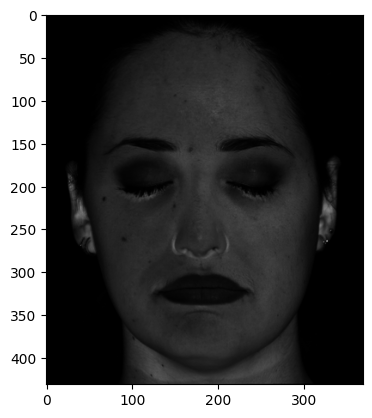

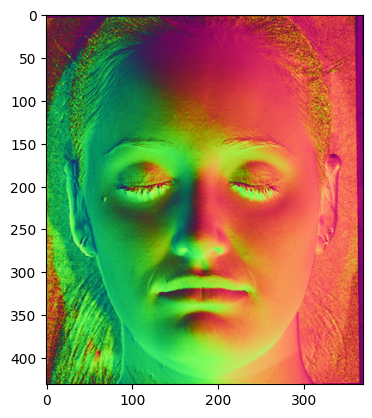

In [48]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    # Albedos are the scale of the pseudonormals
    albedos = np.linalg.norm(B, axis=0)
    # Normals are the normalized pseudonormals
    normals = B/albedos
    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

**A:**

The face is defined as a surface $ S = \begin{bmatrix} x \\ y \\ f(x, y)\end{bmatrix}$. We wish to establish a relationship between the surface normal and the partial derivatives of the $f(x)$. We know that the normals will always be perpendicular to the tangent planes of the surface; the partial derivatives describe vectors on these tangent plane. We can exploit this relationship to express the normals in terms of the partials.

1. The tangent vectors in the $x$ and $y$ are obtained by taking the corresponding partials,

$$ S_x = \begin{bmatrix} 1 \\ 0 \\ f_x\end{bmatrix} $$
$$ S_y = \begin{bmatrix} 0 \\ 1 \\ f_y\end{bmatrix} $$

2. To obtain a vector in the direction of the normal, that is perpendicular to both $S_x$ and $S_y$ we take their cross product.

$$ S_x \times S_y  = \begin{bmatrix} (0)(f_y) - f_x(1) \\ f_x(0) - (1)(f_y) \\ (1)(1) - (0)(0) \end{bmatrix} $$
$$ S_x \times S_y = \begin{bmatrix} - f_x \\ -f_y \\ 1\end{bmatrix} $$

3. We know that $n$ is proportional to $S_x \times S_y$, to ger rid of the notion of scale we can normalize $S_x \times S_y$ such that $n = \text{norm}(S_x \times S_y)$

$$ n = \frac{( - f_x -f_y + 1)}{\sqrt{f_x^2 + f_y^2 + 1}} $$
$$ n_1 = \frac{(-f_x)}{\sqrt{f_x^2 + f_y^2 + 1}} $$
$$ n_2 = \frac{(-f_y)}{\sqrt{f_x^2 + f_y^2 + 1}} $$
$$ n_3 = \frac{(1)}{\sqrt{f_x^2 + f_y^2 + 1}} $$

4. We can use $n_3$ to write the partials in terms of the components of the normal

$$ \frac{n_1}{n_3} = \frac{(-f_x)}{\sqrt{f_x^2 + f_y^2 + 1}}\frac{\sqrt{f_x^2 + f_y^2 + 1}}{1} = -f_x$$
$$ \frac{n_2}{n_3} = \frac{(-f_y)}{\sqrt{f_x^2 + f_y^2 + 1}}\frac{\sqrt{f_x^2 + f_y^2 + 1}}{1} = -f_y$$

5. Therfore, 

$$f_x = - \frac{n_1}{n_3}$$
$$f_y = -\frac{n_2}{n_3}$$



### Q 1 (g): Understanding integrability of gradients (5 points)

Given $g = \begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}$.

0. Calculate the $g_x(x_i, y_j ) = g(x_i+1, y_j ) − g(x_i, y_j )$ and $g_y(x_i, y_j ) = g(x_i, y_j+1 ) − g(x_i, y_j )$

$$g_x = \begin{bmatrix}
2-1 & 3-2 & 4-3   \\
6-5 & 7-6 & 8-7   \\
10-9 & 11-10 & 12-11  \\
14-13 & 15-14 & 16-15
\end{bmatrix}$$

$$ g_x = \begin{bmatrix}
1 & 1 & 1  \\
1 & 1 & 1  \\
1 & 1 & 1  \\
1 & 1 & 1
\end{bmatrix}$$

$$ g_y = \begin{bmatrix}
5-1 & 6-2 & 7-3 & 8-4 \\
9-5 & 10-6 & 11-7 & 12-8 \\
13-9 & 14-10 & 15-11 & 16-12 \\
\end{bmatrix}$$

$$ g_y = \begin{bmatrix}
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
\end{bmatrix}$$

1. Use $g_x$ to construct the first row of $g$, then use $g_y$ to construct the rest of $g$

For the first row, and using $g(0,0) = g_x(0,0)$ we obtain

$$ \hat{g} = \begin{bmatrix}
1 & 1+1 = 2 & 2+1 = 3 & 3+1 = 4 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}$$

For the rest, 

$$ \hat{g} = \begin{bmatrix}
1      & 1+1 = 2 & 2+1 = 3 & 3+1 = 4  \\
1+4=5  & 2+4=6   & 3+4=7   & 4+4=8    \\
5+4=9  & 6+4=10  & 7+4=11  & 8+4-12    \\
9+4=13 & 10+4=14 & 11+4=15 & 12+4=16
\end{bmatrix} $$


We see that .

2. Use $g_y$ to construct the first column of $g$, then use $g_x$ to construct the rest of $g$.

$$ \hat{g} = \begin{bmatrix}
1      & 0 & 0 & 0 \\
1+4=5  & 0 & 0 & 0 \\
5+4=9  & 0 & 0 & 0 \\
9+4=13 & 0 & 0 & 0
\end{bmatrix}$$

Now applying $g_x$ iteratively, 

$$ \hat{g} = \begin{bmatrix}
1      & 2  & 3  & 4 \\
1+4=5  & 6  & 7  & 8 \\
5+4=9  & 10 & 11 & 12 \\
9+4=13 & 14 & 15 & 16
\end{bmatrix}$$


In this case, $\hat{g} = g$. Confirming that $g_x$ and $g_y$ are integrable.

### Q 1 (h): Shape estimation (10 points)

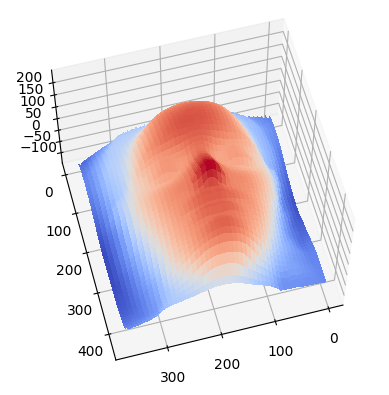

In [ ]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None
    n1, n2, n3 = normals[0, :], normals[1, :], normals[2, :]
    
    # Estimate depth partials
    depth_dx = -n1/n3
    depth_dy = -n2/n3
    depth_dx = depth_dx.reshape(s)
    depth_dy = depth_dy.reshape(s)
    
    # Use Frankot-Chellappa to get surface
    surface = integrateFrankot(depth_dx, depth_dy)
    
    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

YOUR ANSWER HERE...

---

### Q 2 (b): Calculation and visualization (10 points)

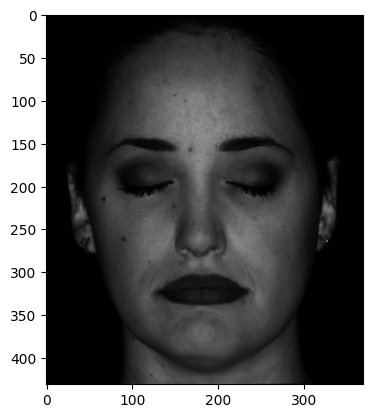

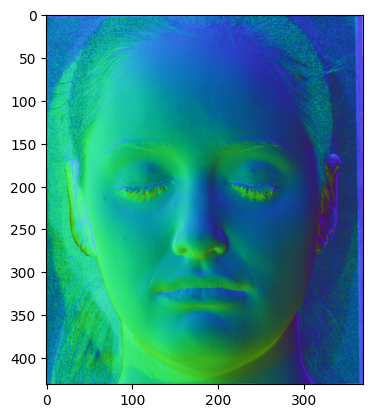

In [ ]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

YOUR ANSWER HERE...

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

YOUR ANSWER HERE...

---

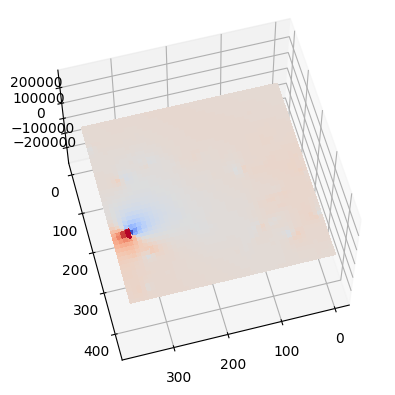

In [ ]:
# Part 2 (d)
### YOUR CODE HERE
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

YOUR ANSWER HERE...

---


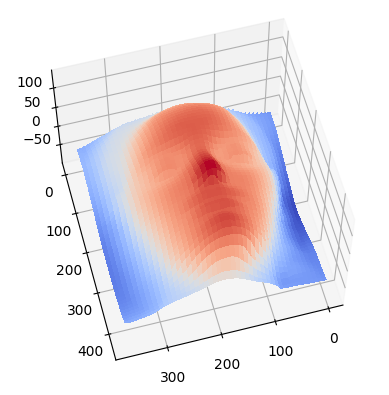

In [ ]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE
### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

YOUR ANSWER HERE...

---

<IPython.core.display.Javascript object>

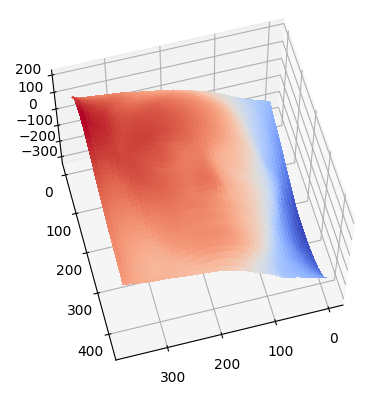

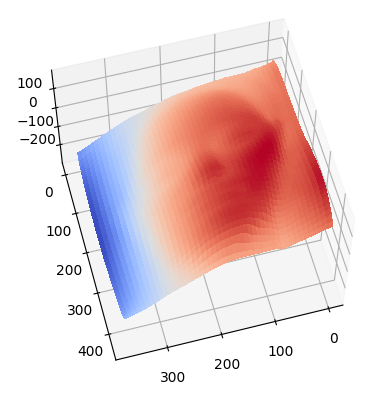

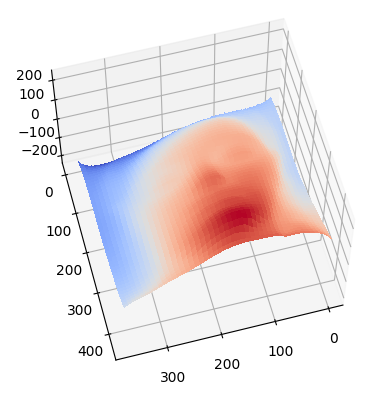

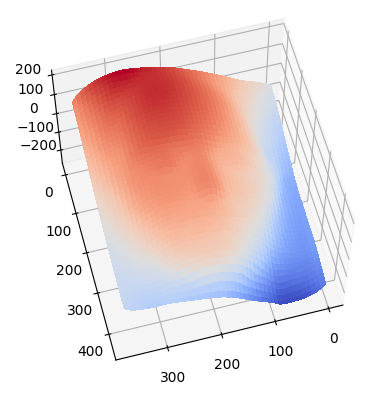

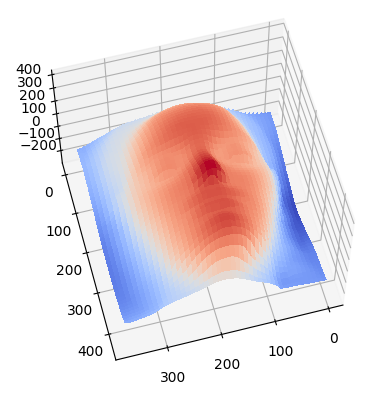

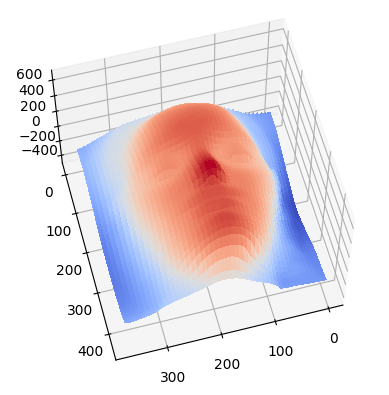

In [ ]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE
### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

YOUR ANSWER HERE...

---

### Q 2 (h): More measurements

---

YOUR ANSWER HERE...

---